In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
# Importing playlist dataframes
df = pd.read_csv('data/encoded_playlist_songs.csv')
df_fav = pd.read_csv('data/favorite_songs.csv')

### Preparing data for model

In [3]:
# Remove song name, artist, album
df = pd.concat([df, df_fav], axis=0)
df.shape

(9819, 13)

In [4]:
df.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,7MAibcTli4IisCtbHKrGMh,242096,90,0.586,0.1820,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4,0
1,5QO79kh1waicV47BqGRL3g,215626,97,0.680,0.0212,0.826,0.000012,0.5430,-5.487,0.0309,118.051,4,0
2,1diS6nkxMQc3wwC4G1j0bh,165506,88,0.722,0.0319,0.588,0.000000,0.1830,-5.932,0.0544,134.010,4,0
3,4u4NyuceXP7Uzh7XFJKCr1,170813,89,0.658,0.0106,0.634,0.000000,0.1320,-5.797,0.0413,139.980,4,0
4,3Ofmpyhv5UAQ70mENzB277,132780,94,0.778,0.1750,0.695,0.000000,0.1500,-6.865,0.0913,149.996,4,0


In [5]:
df['favorite'].value_counts()

0    9769
1      50
Name: favorite, dtype: int64

# Data Prep Contd, Model Selection & Hyperparameter Tuning

In [6]:
# Importing required libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics 
from sklearn.metrics import f1_score
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

## Creating train & test sets

In [7]:
# Shuffle your dataset 
shuffle_df = df.sample(frac=1)

# Define a size for your train set 
train_size = int(0.8 * len(df))

# Split dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:]

In [8]:
train_set.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
9735,46nYMfEIsocWQTpKG3Cf9y,309706,39,0.516,0.87500,0.214,0.02750,0.1240,-14.444,0.0298,134.555,3,0
5802,5IH5AcpMQCGSv7vtAL5c6X,299255,49,0.636,0.35900,0.776,0.00141,0.5330,-4.019,0.3350,120.019,4,0
5465,4jvCYgzFijnYGxqQcJgRnu,211200,35,0.673,0.00112,0.979,0.85700,0.0497,-4.789,0.0528,125.020,4,0
5557,6Eo6VMANKQi3Zc1IdkDfSp,134600,53,0.713,0.28100,0.488,0.88500,0.2770,-10.278,0.3210,177.837,4,0
3160,66y3v3HpE6kjIo7k2UnwDd,267986,48,0.765,0.02100,0.547,0.15100,0.7810,-7.290,0.0368,99.999,4,0


In [9]:
X = train_set.drop(columns=['favorite', 'track_id'])
y = train_set.favorite

X.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
9735,309706,39,0.516,0.87500,0.214,0.02750,0.1240,-14.444,0.0298,134.555,3
5802,299255,49,0.636,0.35900,0.776,0.00141,0.5330,-4.019,0.3350,120.019,4
5465,211200,35,0.673,0.00112,0.979,0.85700,0.0497,-4.789,0.0528,125.020,4
5557,134600,53,0.713,0.28100,0.488,0.88500,0.2770,-10.278,0.3210,177.837,4
3160,267986,48,0.765,0.02100,0.547,0.15100,0.7810,-7.290,0.0368,99.999,4


In [10]:
# Checking for imbalance
y.value_counts()

0    7817
1      38
Name: favorite, dtype: int64

Since the number of favorite songs is so little compared to non-favorite songs, I decided to oversample the favorite class to train a classificaiton model on. 

In [11]:
# Train / Split Data
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X, y) 

In [12]:
X_train.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,309706,39,0.516,0.87500,0.214,0.02750,0.1240,-14.444,0.0298,134.555,3
1,299255,49,0.636,0.35900,0.776,0.00141,0.5330,-4.019,0.3350,120.019,4
2,211200,35,0.673,0.00112,0.979,0.85700,0.0497,-4.789,0.0528,125.020,4
3,134600,53,0.713,0.28100,0.488,0.88500,0.2770,-10.278,0.3210,177.837,4
4,267986,48,0.765,0.02100,0.547,0.15100,0.7810,-7.290,0.0368,99.999,4


In [13]:
# Checking if imbalance is gone
y_train.value_counts()

0    7817
1    7817
Name: favorite, dtype: int64

Now that the classes in the train set are balanced, the model will be less biased towards a song being a non-favorite and be more accurate on the test data and real life application.

In [14]:
test_set.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
273,5fPW2jB6YqAUHmbVCDYkCu,195000,2,0.194,0.979000,0.0558,0.897,0.1010,-30.996,0.0411,93.491,4,0
1796,1HM3k9oiGCQwNqG8kP35bt,315150,44,0.400,0.000051,0.9060,0.657,0.2780,-4.761,0.0580,100.052,4,0
5929,6skTPlJtkpqN7mM95QfsUD,438145,47,0.317,0.000693,0.9420,0.369,0.3130,-8.533,0.0437,128.017,4,0
6239,418U2fvc3WIoc1xIl7r0ul,189677,40,0.805,0.000147,0.9430,0.773,0.1350,-5.298,0.0905,123.981,4,0
1669,0lgUn1bN5txujF60W7YAbv,173493,68,0.873,0.623000,0.6000,0.000,0.0701,-7.178,0.1920,124.010,4,0


In [15]:
# Setting test datasets
X_test = test_set.drop(columns=['favorite', 'track_id'])
y_test = test_set['favorite']

In [16]:
X_test.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
273,195000,2,0.194,0.979000,0.0558,0.897,0.1010,-30.996,0.0411,93.491,4
1796,315150,44,0.400,0.000051,0.9060,0.657,0.2780,-4.761,0.0580,100.052,4
5929,438145,47,0.317,0.000693,0.9420,0.369,0.3130,-8.533,0.0437,128.017,4
6239,189677,40,0.805,0.000147,0.9430,0.773,0.1350,-5.298,0.0905,123.981,4
1669,173493,68,0.873,0.623000,0.6000,0.000,0.0701,-7.178,0.1920,124.010,4


In [17]:
# Checking for imbalance in test set
y_test.value_counts()

0    1952
1      12
Name: favorite, dtype: int64

## Testing models

I am using logistic regression as a baseline to compare my other models to. I am using two other models: DecisionTreeClassifier and RandomForestClassifier. I am expecting these models to outperform logistic regression due to their sequential decision making.

In [18]:
%%time
# Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=400).fit(X_train, y_train)
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
print(np.mean(lr_scores))

0.8622057012682711
CPU times: user 2.98 s, sys: 458 ms, total: 3.44 s
Wall time: 911 ms


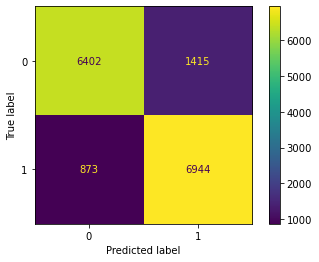

In [19]:
# Logistic Regression confusion matrix
lr_preds = lr.predict(X_train)
plot_confusion_matrix(lr, X_train, y_train)

In [20]:
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    'max_depth':[3, 4, 5, 6, 10, 15,20,30],
}
dtc = Pipeline([('CV',GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [21]:
%%time
# Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=30).fit(X_train, y_train)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

CPU times: user 1.95 s, sys: 19.9 ms, total: 1.97 s
Wall time: 1.99 s


0.9945132519348284

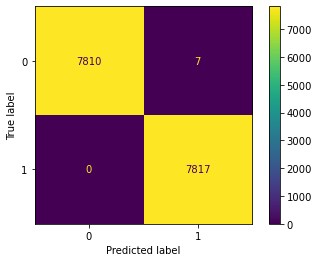

In [22]:
# Decision Tree Classifier confusion matrix
plot_confusion_matrix(dt, X_train, y_train)

In [23]:
%%time
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[3, 6,12,15,20],
    'n_estimators':[10, 20,30]
}
clf = Pipeline([('CV',GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

CPU times: user 25 s, sys: 321 ms, total: 25.4 s
Wall time: 25.8 s


{'max_depth': 20, 'n_estimators': 30}

In [24]:
%%time
# RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 10, max_depth = 20).fit(X_train, y_train))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

CPU times: user 2.86 s, sys: 39.7 ms, total: 2.9 s
Wall time: 2.94 s


0.9975131992617186

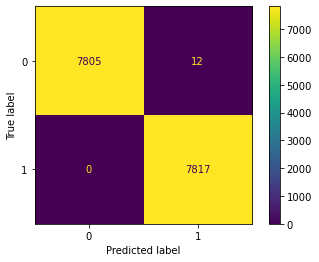

In [25]:
plot_confusion_matrix(rf, X_train, y_train)

Although the RandomForestClassifier had the highest accuracy, the confusion matrix showed the DecisionTreeClassifier truly had the higher accuracy because it has less false positives and negatives.

Therefore, I will be using the DecisionTreeClassifier as my recommendation algorithm.

### Using algorithm on test data

In [26]:
# Checking for imbalance
y_test.value_counts()

0    1952
1      12
Name: favorite, dtype: int64

In [27]:
# Building a pipeline to use on regular data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=30))
pipe.fit(X_train, y_train)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('dt', DecisionTreeClassifier(max_depth=30))])

pipe.score(X_test, y_test)

0.9903258655804481

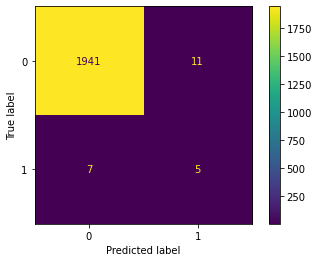

In [28]:
plot_confusion_matrix(dt, X_test, y_test)

After running evaluating the algorithm on test data, it shows there were seventeen false positives and negatives combined. It was able to correctly recommend four songs, but mislabeled 11 songs as future favorites; however, this might be a good thing. The algorithm only recommended four songs, but for the purpose of this project, I would like for there to be atleast 15 songs in the playlist. These false positives can mitigate the issue of not enough songs.

## Predicting songs and saving to dataset

In [29]:
# Reloading the original dataframe to test the model on
df = pd.read_csv('data/encoded_playlist_songs.csv')

In [30]:
df.head()

,track_id,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,favorite
0,7MAibcTli4IisCtbHKrGMh,242096,90,0.586,0.1820,0.616,0.000000,0.0927,-7.964,0.0324,148.088,4,0
1,5QO79kh1waicV47BqGRL3g,215626,97,0.680,0.0212,0.826,0.000012,0.5430,-5.487,0.0309,118.051,4,0
2,1diS6nkxMQc3wwC4G1j0bh,165506,88,0.722,0.0319,0.588,0.000000,0.1830,-5.932,0.0544,134.010,4,0
3,4u4NyuceXP7Uzh7XFJKCr1,170813,89,0.658,0.0106,0.634,0.000000,0.1320,-5.797,0.0413,139.980,4,0
4,3Ofmpyhv5UAQ70mENzB277,132780,94,0.778,0.1750,0.695,0.000000,0.1500,-6.865,0.0913,149.996,4,0


Since the model has a very niche idea of what a favorite song is based on the favorites dataset, it is necessary to accept songs that might not be absolute favorites. This is done by using a threshold and sklearn's proba function.

I've defined the threshold as 0.3 to get approximately 20 song recommendations from nearly 10,000 songs to choose from. You can play with this value if you'd like more or less songs in the recommendation playlist.

In [31]:
# Predicting if a song is a favorite
prob_preds = pipe.predict_proba(df.drop(['favorite','track_id'], axis=1))
threshold = 0.30 # define threshold here
preds = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
df['prediction'] = preds

In [32]:
df['prediction'].value_counts()

0    9750
1      19
Name: prediction, dtype: int64

## Building the playlist from recommended songs

In [33]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import oauth2

In [34]:
# Insert your Spotify username and the credentials that you obtained from spotify developer
cid = '58ecd7aadf294b9aa038a3080ef670cb'
secret = '4a277ac2c0a744eea5c839b1ecb27002'
redirect_uri='http://localhost:7777/callback'
username = 'yvngflash_'

In [35]:
# Once the Authorisation is complete, we just need to `sp` to call the APIs
scope = 'user-top-read playlist-modify-private playlist-modify-public'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [36]:
# Creating a function that builds a playlist in the user's spotify account
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [37]:
create_playlist(sp, username, 'Your New Jams', 'This playlist was created using python!')

In [38]:
# Function to check if the playlist was created successfully
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [39]:
fetch_playlists(sp,username).head()

,id,name,#tracks
0,1C36hdGo2BJ4r7cMcw33Z4,Your New Jams,0
1,2IILGkkdPYQhCm5FhleTH4,Python Playlist,35
2,4OqhYtuar9Zcjj4djxIHMo,GOSPEL,35
3,3ALg99PJwQoQTZUgVOxZCr,LUCKI,38
4,4STXJNA3A9Hkz7soJiPz4s,POSITIVITY,77


In [40]:
# Getting the playlist ID of the most recently made playlist so we can add songs to it later
playlist_id = fetch_playlists(sp,username)['id'][0]

In [41]:
# Function to add selected songs to playlist
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 50])
        index += 50

In [42]:
# Adding songs to playlist
list_track = df.loc[df['prediction']  == 1]['track_id']
enrich_playlist(sp, username, playlist_id, list_track)

Now check your Spotify playlists; you'll see a playlist titled 'Your New Jams'. Enjoy!